# Notebook error analysis 

## Refining error types - Vectorization and clustering method selection


use a subset of the GitHub error dataset --> ename == valueerror

### Clustering value errors

load tokenized error dataset, evalue_tokenized

In [1]:
import pandas as pd 
import cluster_util

path = r"C:\Users\yirwa29\Downloads\Dataset-Nb\nbdata_g_error\analysis_gerr"

df2_err = pd.read_excel(path + '/nberror_g_all_p6_evaluetokenized.xlsx')
df2_err_ename = df2_err[df2_err['ename']=='valueerror']
err_descs = df2_err_ename['evalue_tokenized'].values.astype('U')

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1 Vectorization
##### 1. tfidf
too high dimension - 7843

In [2]:
X_tfidf = cluster_util.vectorizer_tfidf(err_descs)
X_tfidf.shape

(15570, 7843)

In [3]:
import numpy as np

with open(path+'/cluster_selection_g_valueerror/nberror_g_valueerror_embeddings_tfidf.txt', 'wb') as f:
    np.save(f, X_tfidf)

##### 2. sentence transformers

https://github.com/UKPLab/sentence-transformers

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence to vector, dimension -384

2 embeddings with different preprocessing

In [4]:
X_transformers = cluster_util.vectorizer_sentence2vec(err_descs)
X_transformers.shape

modules.json: 100%|███████████████████████████████████████████████████████████████████████████| 349/349 [00:00<?, ?B/s]
C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yirwa29\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message

(15570, 384)

In [5]:
with open(path+'/cluster_selection_g_valueerror/nberror_g_valueerror_embeddings_transformers.txt', 'wb') as f:
    np.save(f, X_transformers)

In [6]:
df2_err_ename['evalue_tokenized_transformer'] = df2_err_ename['evalue'].apply(cluster_util.preprocess_text_transformer)
err_descs1 = df2_err_ename['evalue_tokenized_transformer'].values.astype('U')

X_transformers1 = cluster_util.vectorizer_sentence2vec(err_descs1)

with open(path+'/cluster_selection_g_valueerror/nberror_g_valueerror_embeddings_transformers_1.txt', 'wb') as f:
    np.save(f, X_transformers1)

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_20732\700486951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_err_ename['evalue_tokenized_transformer'] = df2_err_ename['evalue'].apply(cluster_util.preprocess_text_transformer)


##### 3. word embeddings - GloVe

Turn sentences to vectors via word embeddings by taking the mean/sum of all word embeddings of the sentence

using GloVe with dimension 200

In [7]:
glove_vectors = cluster_util.load_glove("C:/Users/yirwa29/Downloads/Dataset-Nb/glove.6B/glove.6B.200d.txt")
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])
X_glove.shape

Loaded 400000 word vectors from GloVe.


(15570, 200)

In [8]:
with open(path+'/cluster_selection_g_valueerror/nberror_g_valueerror_embeddings_glove.txt', 'wb') as f:
    np.save(f, X_glove)

In [9]:
df2_err_ename.to_excel(path+"/cluster_selection_g_valueerror/nberror_g_cluster_valueerror.xlsx", index=False, engine='xlsxwriter')

### 2. Clustering with vectorized error values


In [2]:
import pandas as pd
import numpy as np 
import cluster_util

path = r"C:\Users\yirwa29\Downloads\Dataset-Nb\nbdata_g_error\analysis_gerr/cluster_selection_g_valueerror"
path_file = path+"/nberror_g_cluster_valueerror.xlsx"

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### 1. tfidf

In [3]:
df2_err_ename = pd.read_excel(path_file)
with open(path+'/nberror_g_valueerror_embeddings_tfidf.txt', 'rb') as f:
    X_tfidf = np.load(f)

In [4]:
## kmeans

In [5]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_tfidf, K_range = K_range)

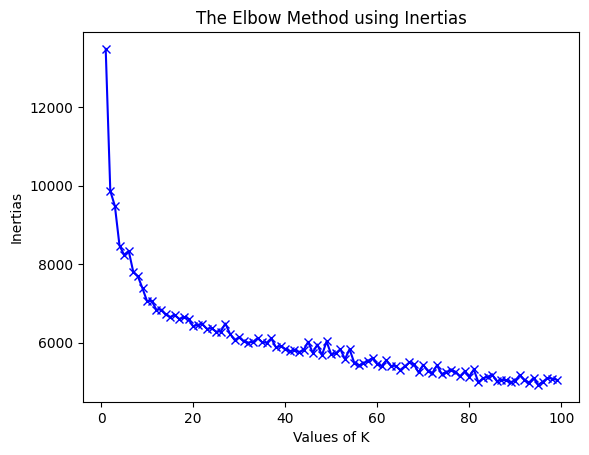

In [6]:
import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [77]:
num_clusters = 40
res = cluster_util.cluster_kmeans(X_tfidf, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

In [58]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_tfidf"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [9]:
## dbscan

In [10]:
eps_tfidf = cluster_util.epsilon_search_dbscan(X_tfidf)
print(eps_tfidf)
res = cluster_util.cluster_dbscan(X_tfidf, eps=eps_tfidf, min_samples=30)

0.6626269173058967
Estimated no. of clusters: 35
Estimated no. of noise points: 6428


In [11]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [12]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_tfidf"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [13]:
## OPTICS

In [14]:
res = cluster_util.cluster_optics(X_tfidf, min_samples = 30)

Estimated no. of clusters: 41
Estimated no. of noise points: 6179


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [15]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [16]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_tfidf"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

##### 2. sentence transformers

In [17]:
df2_err_ename = pd.read_excel(path_file)
with open(path+'/nberror_g_valueerror_embeddings_transformers.txt', 'rb') as f:
    X_transformers = np.load(f)
with open(path+'/nberror_g_valueerror_embeddings_transformers_1.txt', 'rb') as f:
    X_transformers1 = np.load(f)

In [18]:
## kmeans

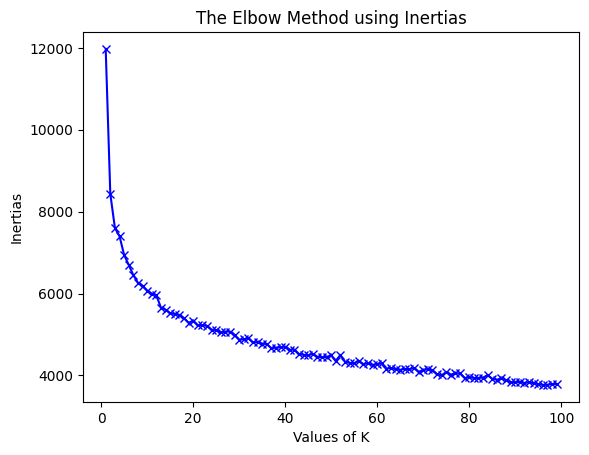

In [19]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_transformers, K_range = K_range) # X_transformers1

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [79]:
num_clusters = 40
res = cluster_util.cluster_kmeans(X_transformers, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

In [21]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_transformers"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [81]:
# transformer1
num_clusters = 40
res = cluster_util.cluster_kmeans(X_transformers1, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

In [23]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_transformers1"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [24]:
## dbscan

In [25]:
eps_transformers = cluster_util.epsilon_search_dbscan(X_transformers)
print(eps_transformers)
res = cluster_util.cluster_dbscan(X_transformers, eps=eps_transformers, min_samples=30)

0.5247714144499463
Estimated no. of clusters: 31
Estimated no. of noise points: 6812


In [26]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [27]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_transformers"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [28]:
# transformer 1
eps_transformers1 = cluster_util.epsilon_search_dbscan(X_transformers1)
print(eps_transformers1)
res = cluster_util.cluster_dbscan(X_transformers1, eps=eps_transformers1, min_samples=30)

0.4621702878316836
Estimated no. of clusters: 59
Estimated no. of noise points: 8309


In [29]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [30]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_transformers1"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [31]:
## OPTICS

In [32]:
res = cluster_util.cluster_optics(X_transformers, min_samples = 30)

Estimated no. of clusters: 42
Estimated no. of noise points: 6386


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [33]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(49, df2_err_ename[['evalue','cluster']])

In [34]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_transformers"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [35]:
# transformer 1
res = cluster_util.cluster_optics(X_transformers1, min_samples = 30)

Estimated no. of clusters: 89
Estimated no. of noise points: 9213


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [36]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [37]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_transformers1"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

##### 3. word embeddings - GloVe

In [38]:
df2_err_ename = pd.read_excel(path_file)
with open(path+'/nberror_g_valueerror_embeddings_glove.txt', 'rb') as f:
    X_glove = np.load(f)

In [39]:
## kmeans

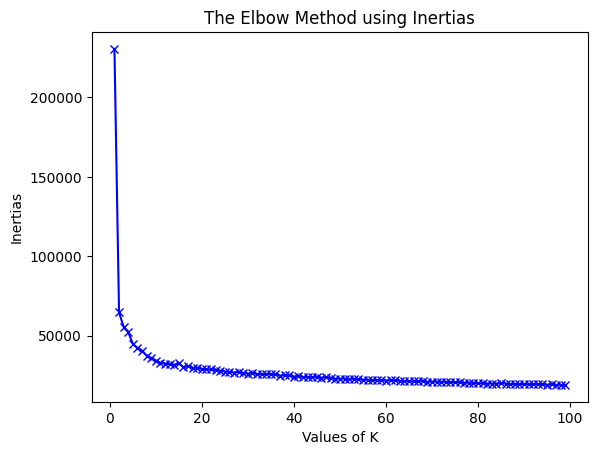

In [40]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_glove, K_range = K_range)

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [82]:
num_clusters = 20
res = cluster_util.cluster_kmeans(X_glove, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

In [42]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_glove"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [43]:
## dbscan

In [44]:
eps_glove = cluster_util.epsilon_search_dbscan(X_glove)
print(eps_glove)
res = cluster_util.cluster_dbscan(X_glove, eps=eps_glove, min_samples=30)

1.006667390245218
Estimated no. of clusters: 34
Estimated no. of noise points: 5729


In [45]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [46]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_glove"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [47]:
## OPTICS

In [48]:
res = cluster_util.cluster_optics(X_glove, min_samples = 30)

Estimated no. of clusters: 41
Estimated no. of noise points: 5593


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [49]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [50]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_glove"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

### 3. Evaluate vectorization and clustering methods

In [51]:
df2_err_ename.columns

Index(['fname', 'ename', 'evalue', 'evalue_tokenized', 'traceback',
       'lib_parsed', 'evalue_tokenized_transformer', 'cluster_km_tfidf',
       'cluster_dbscan_tfidf', 'cluster_optics_tfidf',
       'cluster_km_transformers', 'cluster_km_transformers1',
       'cluster_dbscan_transformers', 'cluster_dbscan_transformers1',
       'cluster_optics_transformers', 'cluster_optics_transformers1',
       'cluster_km_glove', 'cluster_dbscan_glove', 'cluster_optics_glove'],
      dtype='object')

In [85]:
import pandas as pd
import numpy as np
import cluster_util

path = r'C:\Users\yirwa29\Downloads\Dataset-Nb\nbdata_g_error\analysis_gerr\cluster_selection_g_valueerror'
path_file = path+"/nberror_g_cluster_valueerror.xlsx"

df2_err_ename = pd.read_excel(path_file)
with open(path+'/nberror_g_valueerror_embeddings_tfidf.txt', 'rb') as f:
    X_tfidf = np.load(f)
with open(path+'/nberror_g_valueerror_embeddings_transformers.txt', 'rb') as f:
    X_transformers = np.load(f)
with open(path+'/nberror_g_valueerror_embeddings_transformers_1.txt', 'rb') as f:
    X_transformers1 = np.load(f)
with open(path+'/nberror_g_valueerror_embeddings_glove.txt', 'rb') as f:
    X_glove = np.load(f)

In [86]:
arr_eval = np.zeros((3,4))
name_cols = ['tfidf','word2vec','transformer','transformer1']
name_rows = ['kmeans','dbscan','optics']

#ss_km_tfidf
arr_eval[0,0] = cluster_util.eval_cluster_silhouette(X_tfidf, df2_err_ename['cluster_km_tfidf'])
#ss_km_glove
arr_eval[0,1] = cluster_util.eval_cluster_silhouette(X_glove, df2_err_ename['cluster_km_glove'])
#ss_km_transformers
arr_eval[0,2] = cluster_util.eval_cluster_silhouette(X_transformers, df2_err_ename['cluster_km_transformers'])
#ss_km_transformers1
arr_eval[0,3] = cluster_util.eval_cluster_silhouette(X_transformers1, df2_err_ename['cluster_km_transformers1'])

#ss_dbscan_tfidf
arr_eval[1,0] = cluster_util.eval_cluster_silhouette(X_tfidf[df2_err_ename['cluster_dbscan_tfidf']!=-1], 
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_tfidf']!=-1, 'cluster_dbscan_tfidf'])
#ss_dbscan_glove
arr_eval[1,1] = cluster_util.eval_cluster_silhouette(X_glove[df2_err_ename['cluster_dbscan_glove']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_glove']!=-1, 'cluster_dbscan_glove'])
#ss_dbscan_transformers
arr_eval[1,2] = cluster_util.eval_cluster_silhouette(X_transformers[df2_err_ename['cluster_dbscan_transformers']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_transformers']!=-1, 'cluster_dbscan_transformers'])
#ss_dbscan_transformers1
arr_eval[1,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_dbscan_transformers1']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_transformers1']!=-1, 'cluster_dbscan_transformers1'])
#ss_optics_tfidf
arr_eval[2,0] = cluster_util.eval_cluster_silhouette(X_tfidf[df2_err_ename['cluster_optics_tfidf']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_tfidf']!=-1, 'cluster_optics_tfidf'])
#ss_optics_glove
arr_eval[2,1] = cluster_util.eval_cluster_silhouette(X_glove[df2_err_ename['cluster_optics_glove']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_glove']!=-1, 'cluster_optics_glove'])
#ss_optics_transformers
arr_eval[2,2] = cluster_util.eval_cluster_silhouette(X_transformers[df2_err_ename['cluster_optics_transformers']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_transformers']!=-1, 'cluster_optics_transformers'])
#ss_optics_transformers1
arr_eval[2,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_optics_transformers1']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_transformers1']!=-1, 'cluster_optics_transformers1'])

In [87]:
df_eval = pd.DataFrame(arr_eval, index=name_rows, columns=name_cols)
df_eval

,tfidf,word2vec,transformer,transformer1
kmeans,0.496352,0.549091,0.472624,0.203059
dbscan,0.954203,0.959028,0.960091,0.672226
optics,0.944955,0.972710,0.945297,0.758300


In [88]:
df_eval.to_excel(path+"/nberror_g_cluster_valueerror_eval.xlsx", index=False, engine='xlsxwriter')

selected optimal clustering method + wordembeddings = optics + word2vec(GloVe)